In [11]:
import numpy as np
import xarray as xr
import pygplates
import stripy
import points_in_polygons
import matplotlib.pyplot as plt


# Grid containing data to mask (typically bathymetry, but could be anything?)
ds = xr.open_dataarray('./bathymetry/earth_relief_05m.nc')

# Age coded masking polygons
s = pygplates.FeatureCollection('./shapefiles/TasmantidAnimationPolygons.shp')

# This parameter controls how long it takes for a seamount to be built
# Each seamount will first start to appear at the polygon from_age for the corresponding polygon,
# then finish building at this time + the duration parameter
eruption_duration = 1

# Set the time range to consider, and how closely spaced in time to produce grids
time_min = 0.
time_max = 30.
time_step = 0.1

# Set lat/long extents of area of interest
Xmin = 152.
Xmax = 162.
Ymin = -40.
Ymax = -15.


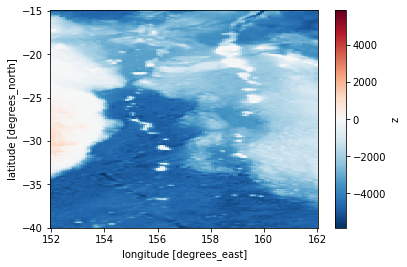

In [2]:

subset_grid = ds.sel(lon=slice(Xmin,Xmax),lat=slice(Ymin,Ymax))

subset_grid.plot()


In [3]:
# create a multipoint from the grid nodes for the point in polygon test
longrid,latgrid = np.meshgrid(subset_grid.lon.data,subset_grid.lat.data)

points = []
for lon,lat in zip(longrid.flatten(),latgrid.flatten()):
    points.append(pygplates.LatLonPoint(lat,lon))
    

In [4]:
# create lists of the polygon geometries, and their ages
rpolygons = []
polygon_ages = []
for poly in s:
    rpolygons.append(poly.get_geometry())
    polygon_ages.append(poly.get_valid_time()[0])
    

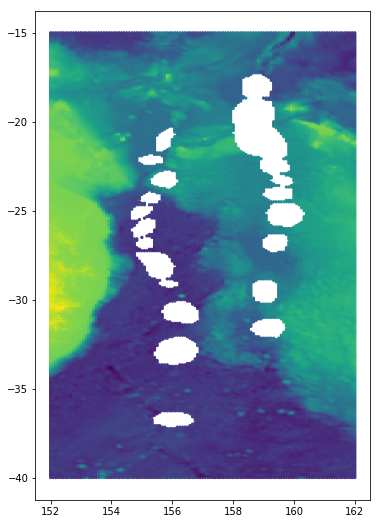

In [5]:
# do the point in polygon test, 
polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons)

lat = []
lon = []
zval = []

lat_outside = []
lon_outside = []
zval_outside = []

for pcp,point,z in zip(polygons_containing_points, points, subset_grid.data.flatten()):
    if pcp is not None:
        lat.append(point.get_latitude())
        lon.append(point.get_longitude())
        zval.append(z)
    else:
        lat_outside.append(point.get_latitude())
        lon_outside.append(point.get_longitude())
        zval_outside.append(z)

plt.figure(figsize=(6,9))
#plt.plot(longrid.flatten(),latgrid.flatten(),'.')
plt.scatter(lon_outside,lat_outside,c=zval_outside,s=5)
#print points

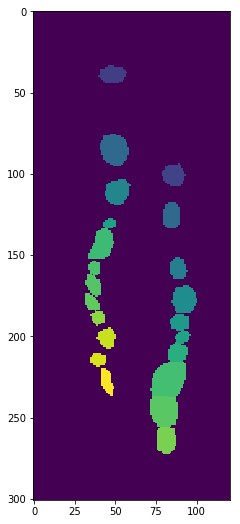

In [6]:
# do point in polygon test to isolate points considered as part of seamounts
polygons_containing_points = points_in_polygons.find_polygons(points, rpolygons, 
                                                              polygon_proxies = polygon_ages)


lat_mask = []
lon_mask = []
zval_mask = []

for pcp,point,z in zip(polygons_containing_points, points, subset_grid.data.flatten()):
    if pcp is not None:
        lat_mask.append(point.get_latitude())
        lon_mask.append(point.get_longitude())
        zval_mask.append(pcp)
        #print pcp
    else:
        lat_mask.append(point.get_latitude())
        lon_mask.append(point.get_longitude())
        zval_mask.append(0)

plt.figure(figsize=(6,9))
#plt.scatter(lon_mask,lat_mask,c=zval_mask,s=5)
plt.imshow(np.array(zval_mask).reshape(subset_grid.data.shape))

seamount_age_grid = np.array(zval_mask).reshape(subset_grid.data.shape)

#print polygons_containing_points


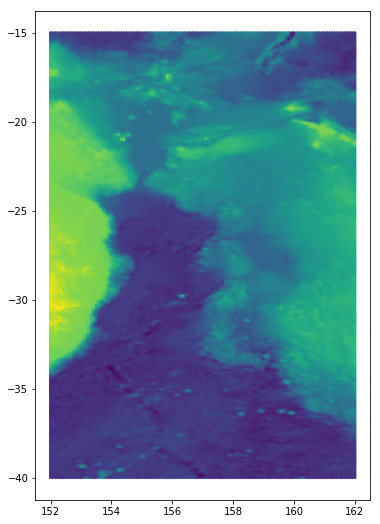

In [7]:

tri = stripy.sTriangulation(lons=np.radians(lon_outside), lats=np.radians(lat_outside))

regional_grid = tri.interpolate(np.radians(longrid.flatten()),np.radians(latgrid.flatten()),zdata=np.array(zval_outside),order=1)[0]

plt.figure(figsize=(6,9))
plt.scatter(longrid.flatten(),latgrid.flatten(),c=regional_grid,s=5)


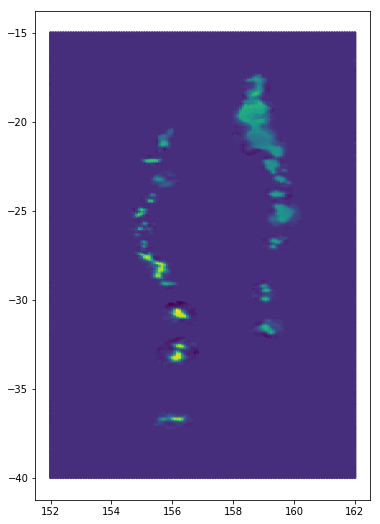

In [8]:
plt.figure(figsize=(6,9))
plt.scatter(longrid.flatten(),latgrid.flatten(),c=subset_grid.data.flatten()-regional_grid,s=5)

In [10]:
regional_grid = regional_grid.reshape(subset_grid.data.shape)

edifice = subset_grid.data - regional_grid


for recon_time in np.arange(time_min,time_max+time_step,time_step):

    seamount_scaling = seamount_age_grid - recon_time

    seamount_scaling[seamount_scaling<0.] = 0.
    seamount_scaling[seamount_scaling>eruption_duration] = eruption_duration

    rbathy = regional_grid + (edifice*seamount_scaling)

    filename = './time_dependent_grids/rbathy_%0.2f.nc' % recon_time
    #cdfwrite2(x,y,TI+edifice.*grid_to_fill,filename);

    ds = xr.DataArray(rbathy, 
                      coords=[('lat',subset_grid.lat.data), ('lon',subset_grid.lon.data)])
    
    ds.to_netcdf(filename, format='NETCDF4_CLASSIC')
    
    print 'Done time %0.2f' % recon_time
    


Done time 0.00
Done time 0.10
Done time 0.20
Done time 0.30
Done time 0.40
Done time 0.50
Done time 0.60
Done time 0.70
Done time 0.80
Done time 0.90
Done time 1.00
Done time 1.10
Done time 1.20
Done time 1.30
Done time 1.40
Done time 1.50
Done time 1.60
Done time 1.70
Done time 1.80
Done time 1.90
Done time 2.00
Done time 2.10
Done time 2.20
Done time 2.30
Done time 2.40
Done time 2.50
Done time 2.60
Done time 2.70
Done time 2.80
Done time 2.90
Done time 3.00
Done time 3.10
Done time 3.20
Done time 3.30
Done time 3.40
Done time 3.50
Done time 3.60
Done time 3.70
Done time 3.80
Done time 3.90
Done time 4.00
Done time 4.10
Done time 4.20
Done time 4.30
Done time 4.40
Done time 4.50
Done time 4.60
Done time 4.70
Done time 4.80
Done time 4.90
Done time 5.00
Done time 5.10
Done time 5.20
Done time 5.30
Done time 5.40
Done time 5.50
Done time 5.60
Done time 5.70
Done time 5.80
Done time 5.90
Done time 6.00
Done time 6.10
Done time 6.20
Done time 6.30
Done time 6.40
Done time 6.50
Done time 